this script is for visualizing the results from the case study

In [37]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

In [38]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive, make_game_superadditive
from src.nucleolus import get_nucleolus
from src.least_core_nucleolus import get_least_core_nucleolus

In [39]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors[1:])
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX to write text
    "font.family": "serif",
    "font.serif": ["Times"], # Use a serif font (LaTeX will substitute the right one)
    
    # 2. MATCH YOUR DOCUMENT PREAMBLE HERE
    # Use the same packages you use in your main document.
    # 'newtxtext,newtxmath' is the modern choice.
    # Use 'mathptmx' if your paper uses that instead.
    "text.latex.preamble": r"\usepackage{newtxtext,newtxmath}", 
    
    # Optional: Match the font size to your document (usually 10pt for IEEE)
    "font.size": 14,
    "axes.labelsize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

C:\Users\carlv\AppData\Local\Temp\ipykernel_29568\1864157650.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


# Set Parameters

In [40]:
# PARAMS
MAKE_GAMES_SUPERADD = True   # use superadditive formulation
MAKE_REALIZED_SUPERADDITIVE = False
USE_SUB_GAME_METHOD = False
SPLIT_FORECASTED_REALIZED = True
devices = ['PV', 'Wind', 'BESS']
N = len(devices)
GAME_types_to_plot = ['Shapley']  # ['Shapley', 'Nucleolus', 'Sub-Game']
# main_path = 'pics/v_TESTING/'
# main_path = 'pics/mp_mid_k/'
# main_path = 'pics/v_N4/'
main_path = 'pics/mp_optimal_spring_v4/'
services = ['FFR + FCR-D']  # list of services to visualize

In [41]:
dvpps_infos = {}  # dictionary to hold dvpp info dataframes
df_forecasted = pd.DataFrame()
df_realized = pd.DataFrame()
dvpp_info = pd.DataFrame()
df_bids = pd.DataFrame()

df_forecasted = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=list(range(N)))
df_forecasted.columns = [tuple(c for c in col if c!='nan') for col in df_forecasted.columns.values]
df_realized = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=list(range(N)))
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
for service in services:
    dvpps_infos[service] = pd.read_csv(f'{main_path}dvpp_info_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

## Pure-Nucleolus Reward Split

In [42]:
# get reward split of devices
players = [c[0] for c in df_forecasted.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_forecasted.index.get_level_values(1), ['E-Value', 'E-Nucleolus', 'R-Value', 'R-Nucleolus']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
for idx, row in df_forecasted.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    if game_is_superadditive(v, players):
        superadditivity_counter += 1
        nucleolus = get_nucleolus(v, players)
    else:
        print(f"for time {idx[0]}, expected game is not superadditive.")
        print(v)
        nucleolus = get_least_core_nucleolus(v, players)
    if is_convex_game(v, players):
        convexity_counter += 1
    if core_nonempty(v, players):
        core_non_empty_counter += 1
    df_reward_split.loc[(idx[1], 'E-Nucleolus'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
    df_reward_split.loc[(idx[1], 'E-Value'), list(p for p in players)] = [v[frozenset({p})] for p in players]
    # 2. Realized game convert to dictionary
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    nucleolus_realized = get_least_core_nucleolus(v_realized, players)
    df_reward_split.loc[(idx[1], 'R-Nucleolus'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
    df_reward_split.loc[(idx[1], 'R-Value'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 0.0, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 13.10625, frozenset({'Wind', 'PV'}): 0.22436, frozenset({'BESS', 'PV'}): 13.10625, frozenset({'Wind', 'BESS'}): 13.10625, frozenset({'Wind', 'BESS', 'PV'}): 13.10625, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 0.15675, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 1.21875, frozenset({'Wind', 'PV'}): 0.12345, frozenset({'BESS', 'PV'}): 1.38014, frozenset({'Wind', 'BESS'}): 1.21875, frozenset({'Wind', 'BESS', 'PV'}): 1.38014, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 2.53787, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 4.03125, frozenset({'Wind', 'PV'}): 1.75392, frozenset({'BESS', 'PV'}): 6.87387, frozenset({'Wind', 'BESS'}): 4.03125, frozenset({'Wind', 'BESS', 'PV'}): 6.999, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.

In [43]:
print(f"For {main_path}, out of {len(df_forecasted)} games, {superadditivity_counter} superadditive, {convexity_counter} convex and {core_non_empty_counter} non-empty core.") 

For pics/mp_optimal_spring_v4/, out of 168 games, 69 superadditive, 68 convex and 140 non-empty core.


# Reward Split with New Method

In [44]:
from src.game_theory_helpers import evaluate_full_game, solve_optimal_partition

In [45]:
df_rewards, df_forecasted, df_realized = evaluate_full_game(df_forecasted, df_realized, MAKE_GAMES_SUPERADD=MAKE_GAMES_SUPERADD,
                                MAKE_REALIZED_SUPERADDITIVE=MAKE_REALIZED_SUPERADDITIVE,
                                USE_SUB_GAME_METHOD=USE_SUB_GAME_METHOD,
                                print_warnings=False,
                                SPLIT_FORECASTED_REALIZED=SPLIT_FORECASTED_REALIZED
                                )

In [46]:
df_rewards.index.names = ['Index', 'Time', 'Value']

In [47]:
df_fc_reward = df_rewards[['PV', 'Wind', 'BESS']].xs(('Forecasted', 'Reward'), level=['Time', 'Value'])
# select only rows where all devices have non-zero forecasted reward
df_nonzero = df_fc_reward[(df_fc_reward > 0).any(axis=1)]

In [48]:
# print type of game for df_nonzero
nonzero_hours = df_nonzero.index.values
print("For NON-ZERO hours:")
print("For FORECASTED game:")
print(df_rewards.loc[(nonzero_hours, 'Forecasted', 'Reward'), 'F-Game Type'].value_counts())
print(f"out of {len(nonzero_hours)}.")
print("For REALIZED game:")
print(df_rewards.loc[(nonzero_hours, 'Realized', 'Reward'), 'R-Game Type'].value_counts())
print(f"out of {len(nonzero_hours)}.")

For NON-ZERO hours:
For FORECASTED game:
F-Game Type
Shapley      161
Nucleolus      1
Name: count, dtype: int64
out of 162.
For REALIZED game:
R-Game Type
Shapley      138
Sub-Game      13
Nucleolus     11
Name: count, dtype: int64
out of 162.


In [49]:
hours = df_rewards.index.get_level_values(0).unique()
print("For ALL hours:")
print("For FORECASTED game:")
print(df_rewards.loc[(hours, 'Forecasted', 'Reward'), 'F-Game Type'].value_counts())
print("For REALIZED game:")
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'R-Game Type'].value_counts())
print(f"out of {len(hours)}.")

For ALL hours:
For FORECASTED game:
F-Game Type
Shapley      167
Nucleolus      1
Name: count, dtype: int64
For REALIZED game:
R-Game Type
Shapley      144
Sub-Game      13
Nucleolus     11
Name: count, dtype: int64
out of 168.


In [50]:
# new multiindex
idxs1 = df_rewards.index.get_level_values(0).unique().values
idxs2 = df_rewards.index.get_level_values(1).unique().values
idxs3 = df_rewards.index.get_level_values(2).unique().values
idxs2_new = []
for i in idxs2:
    # append idx3
    for j in idxs3:
        idxs2_new.append(f'{i}-{j}')

In [51]:
df_rewards.index = pd.MultiIndex.from_product([idxs1, idxs2_new])

In [52]:
df_plot = df_rewards[devices]
df_mean = df_plot.groupby(level=1).mean()
df_mean = df_mean.transpose()

In [53]:
# measure percentage increase of cooperative reward vs individual value
print("Gain of cooperation (Forecasted): ", df_mean.sum()['Forecasted-Reward'] / df_mean.sum()['Forecasted-Value'])
print("Gain of cooperation (Realized): ", df_mean.sum()['Realized-Reward'] / df_mean.sum()['Realized-Value'])


Gain of cooperation (Forecasted):  1.2141899754297136
Gain of cooperation (Realized):  1.1574930221089372


### convert to latex table

In [54]:
from src.latex_helpers import df_to_custom_latex

dates = ['2025-04-12 11:00:00']

In [55]:
# convert tuples to strings for columns
N = len(devices)
def col_map(col):
    if isinstance(col, tuple):
        if len(col)==N:
            return '$N$'
        else:
            return ', '.join([str(c) for c in col])
    else:
        return str(col)

# 3. Generate LaTeX
caption_text = r"Forecasted ($\mathcal{G}_\mathbb{F}$) and Realized ($\mathcal{G}_\mathcal{R}$) Reward Game in Euros with with $\pi(t)=6$€/MW on 9.4.2025 at 9AM"
label_text = "tab:non_empty_core_game"

for date in dates:
    latex_forecasted = df_to_custom_latex(df_forecasted.xs(date, level=1), caption_text, label_text, col_map=col_map)
    print(latex_forecasted)
    latex_output = df_to_custom_latex(df_realized.xs(date, level=1), caption_text, label_text, col_map=col_map)
    print(latex_output)

\begin{table}[ht]
  \centering
  \resizebox{0.5\textwidth}{!}{%
    \begin{tabular}{l|lllllll}
    \toprule
    & PV & Wind & BESS & PV, Wind & PV, BESS & Wind, BESS & $N$ \\
    \midrule
    FFR + FCR-D & 262.7 & 369.8 & 106.7 & 632.4 & 400.9 & 618.5 & 939.0 \\
    \bottomrule
    \end{tabular}%
  }
  \vspace{.1cm}
  \caption{Forecasted ($\mathcal{G}_\mathbb{F}$) and Realized ($\mathcal{G}_\mathcal{R}$) Reward Game in Euros with with $\pi(t)=6$€/MW on 9.4.2025 at 9AM}
  \label{tab:non_empty_core_game}
\end{table}
\begin{table}[ht]
  \centering
  \resizebox{0.5\textwidth}{!}{%
    \begin{tabular}{l|lllllll}
    \toprule
    & PV & Wind & BESS & PV, Wind & PV, BESS & Wind, BESS & $N$ \\
    \midrule
    FFR + FCR-D & 294.2 & 444.0 & 106.7 & 738.2 & 400.9 & 618.5 & 939.0 \\
    \bottomrule
    \end{tabular}%
  }
  \vspace{.1cm}
  \caption{Forecasted ($\mathcal{G}_\mathbb{F}$) and Realized ($\mathcal{G}_\mathcal{R}$) Reward Game in Euros with with $\pi(t)=6$€/MW on 9.4.2025 at 9AM}
  \lab

In [56]:
df_rewards.loc[dates]

PV       Wind        BESS  \
2025-04-12 11:00:00 Forecasted-Value    262.65207  369.76093    106.6875   
                    Forecasted-Reward  287.214625  449.55524  202.251535   
                    Realized-Value      294.19152  443.98975    106.6875   
                    Realized-Reward     302.98435  486.66965    149.3674   

                                      F-Game Type R-Game Type  
2025-04-12 11:00:00 Forecasted-Value      Shapley     Shapley  
                    Forecasted-Reward     Shapley     Shapley  
                    Realized-Value        Shapley     Shapley  
                    Realized-Reward       Shapley     Shapley

## Main Reward Plot

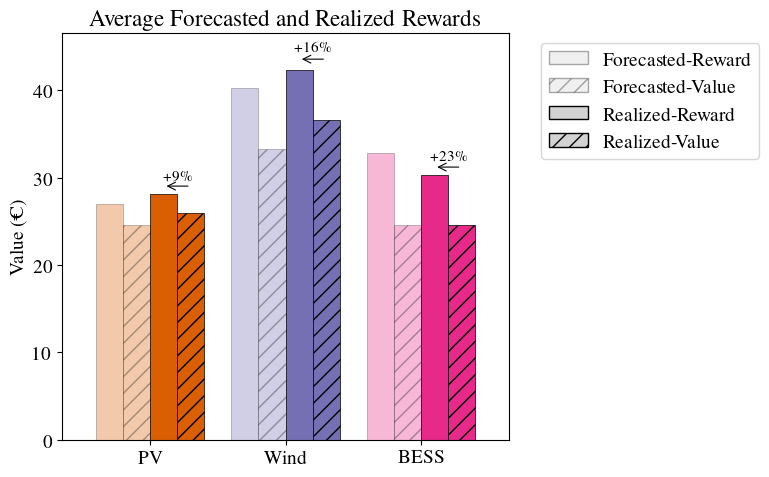

In [57]:
# define colors
device_colors = {
    'PV': (217/255, 95/255, 2/255),
    'Wind': (117/255, 112/255, 179/255),
    'BESS': (231/255, 41/255, 138/255)
}

# 3. Create the Plot
fig, ax = plt.subplots(figsize=(8, 5))
df_mean.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

for col_idx, container in enumerate(ax.containers):
    # --- Determine Style per Column ---
    alpha = 1.0
    hatch = None
    
    # "bars 1 and 2 should be alpha=.5" -> indices 0 and 1
    if col_idx in [0, 1]:
        alpha = 0.33
        
    # "bars 2 and 4 should be hatch='//'\" -> indices 1 and 3
    if col_idx in [1, 3]:
        hatch = '//'
        
    # --- Apply to each bar in the group ---
    # We zip with df_mean.index to know which device (PV/Wind/BESS) the bar belongs to
    for bar, label in zip(container, df_mean.index):
        # Set Color based on device (row index)
        color = device_colors.get(label)
        bar.set_facecolor(color)
        
        # Set Alpha
        bar.set_alpha(alpha)
        
        # Set Hatch
        bar.set_hatch(hatch)

# Highlight difference between the two rightmost columns (col 2 vs col 3)
left_col, right_col = 2, 3
for bar_left, bar_right, device in zip(ax.containers[left_col],
                                       ax.containers[right_col],
                                       df_mean.index):
    left_h = bar_left.get_height()
    right_h = bar_right.get_height()
    if right_h == 0:
        continue
    pct = (left_h - right_h) / right_h * 100

    # x-positions (bar centers)
    x_left = bar_left.get_x() + bar_left.get_width() / 2
    x_right = bar_right.get_x() + bar_right.get_width() / 2
    y = max(left_h, right_h) * 1.03  # place arrow just above the taller bar

    # draw a double-headed arrow
    ax.annotate(
        "",
        xy=(x_right, y),
        xytext=(x_left, y),
        arrowprops=dict(arrowstyle="<-", color="k", lw=0.8),
    )
    # add the percentage text at the midpoint
    ax.text((x_left + x_right) / 2, y * 1.01, f"{pct:+.0f}\\%", ha="center", va="bottom", fontsize=11)

# add a bit more headroom for the arrow/text
ax.set_ylim(0, 1.2 * df_mean.values.max())

# Final Formatting
ax.set_ylabel(r"Value (€)")
ax.set_title(r"Average Forecasted and Realized Rewards")
plt.xticks(rotation=0) # Keep labels horizontal
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out
legend_handles = []
for i, col in enumerate(df_mean.columns):
    hatch = '//' if i in [1, 3] else None
    alpha = 0.33 if i in [0, 1] else 1.0
    legend_handles.append(
        mpatches.Patch(facecolor='lightgrey', edgecolor='black',
                       hatch=hatch, alpha=alpha, label=col)
    )
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylim(0, 1.1*df_mean.values.max())
plt.tight_layout()
# plt.grid()
# plt.savefig('pics/average_forecasted_and_realized_rewards.png', dpi=600, bbox_inches='tight')

In [58]:
def assess_distribution_fit(data, distributions_to_test):
    """
    Fits and compares distributions using the Maximum Likelihood Estimation 
    (MLE) for fitting and the Kolmogorov-Smirnov (KS) test for scoring.
    """
    results = []
    
    # 💡 The list of distributions you want to check
    # Other common choices: 'weibull_min', 'lognorm', 'gamma', 'beta'
    
    for dist_name in distributions_to_test:
        dist = getattr(stats, dist_name)
        
        try:
            # 1. Fit the parameters using Maximum Likelihood Estimation (MLE)
            params = dist.fit(data)
            
            # 2. Perform the KS test to compare the data to the fitted distribution
            # H0: The data comes from the specified distribution
            ks_stat, p_value = stats.kstest(data, dist_name, args=params)
            
            results.append({
                'Distribution': dist_name,
                'KS Statistic': ks_stat, # Lower is better
                'P-Value': p_value      # Higher (ideally > 0.05) is better
            })
        except Exception:
            # Catch distributions that might fail to converge on parameters
            results.append({'Distribution': dist_name, 'KS Statistic': np.nan, 'P-Value': np.nan})
            
    # Sort by the KS Statistic to find the best fit quickly
    df = pd.DataFrame(results).sort_values(by='KS Statistic', ascending=True)
    
    # 
    
    return df

# Example Usage (Use your actual data instead of this random sample)
data = np.random.normal(loc=5, scale=1.5, size=100)
test_dists = ['norm', 't', 'laplace', 'expon']

fit_results = assess_distribution_fit(data, test_dists)
print(fit_results)

  Distribution  KS Statistic       P-Value
0         norm      0.059553  8.491323e-01
1            t      0.059554  8.491260e-01
2      laplace      0.106022  1.964488e-01
3        expon      0.282641  1.464956e-07


For Forecasted-Reward, 13711.3 values above 46.3, 3107.7 values below or equal to 46.3.
For Forecasted-Reward, 86 counts above 46.3, 418 counts below or equal to 46.3.
17.06% of values make up 81.52% of the total reward.
For Realized-Reward, 14195.8 values above 46.3, 2967.3 values below or equal to 46.3.
For Realized-Reward, 87 counts above 46.3, 393 counts below or equal to 46.3.
18.12% of values make up 82.71% of the total reward.


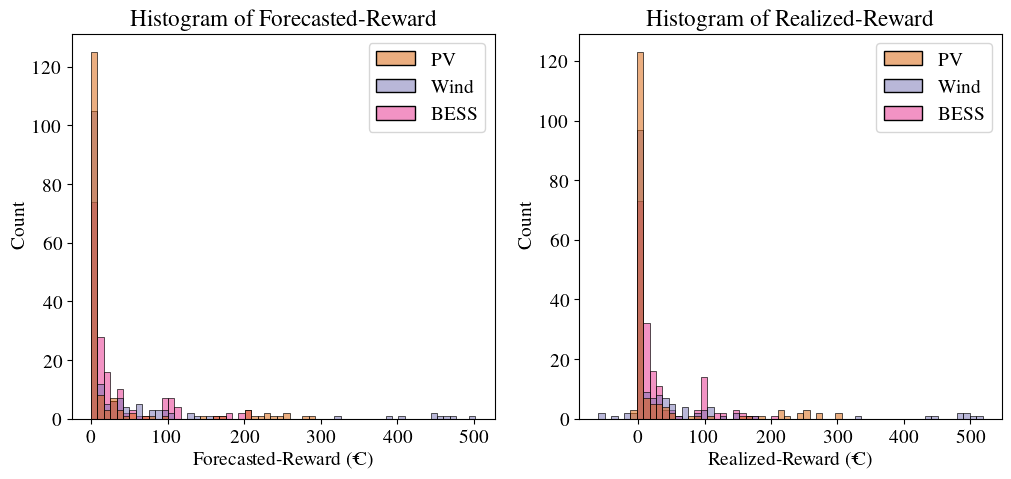

In [59]:
# only plot rewad, not values
df_plot_2 = df_rewards.loc(axis=0)[:, ['Forecasted-Reward', 'Realized-Reward']]

# make 4 subplots axis
fig, axs = plt.subplots(1,2, figsize=(12, 5))

for i, x in enumerate(df_plot_2.index.get_level_values(1).unique().values):
    sns.histplot(df_plot_2.loc(axis=0)[:, x], bins=60, ax=axs[i])
    axs[i].set_title(f'Histogram of {x}')
    axs[i].set_xlabel(f'{x} (€)')
    
    # fit_results = assess_distribution_fit([x for xs in df_plot.loc(axis=0)[:, x].values for x in xs], test_dists)
    # print(fit_results)
    # print the numer of values above
    vals = [xs for x in df_plot_2.loc(axis=0)[:, x].values for xs in x[:3]]
    thresh = 46.3
    above_thresh, above_count = sum(v for v in vals if v > thresh), sum(1 for v in vals if v > thresh)
    below_thresh, below_count = sum(v for v in vals if 0 <= v <= thresh), sum(1 for v in vals if 0 <= v <= thresh)
    print(f'For {x}, {above_thresh:.1f} values above {thresh}, {below_thresh:.1f} values below or equal to {thresh}.')
    print(f'For {x}, {above_count} counts above {thresh}, {below_count} counts below or equal to {thresh}.')
    print(f'{100*above_count/(above_count+below_count):.2f}% of values make up {100*above_thresh/(above_thresh+below_thresh):.2f}% of the total reward.')

# plt.savefig('pics/reward_histograms.png', dpi=600, bbox_inches='tight')

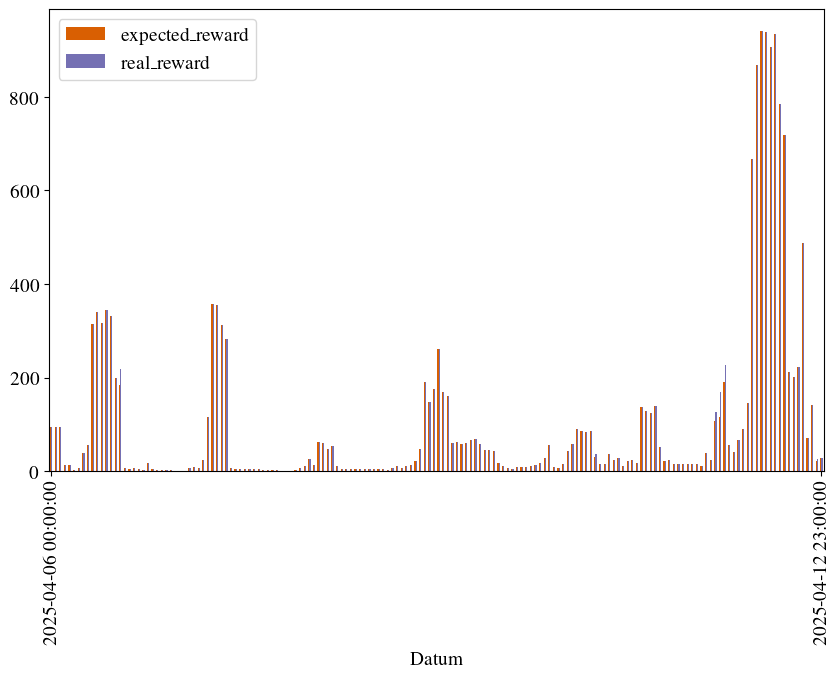

In [60]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
# df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))
# set x axis labels as only start and end time and 5 time points in between
plt.xticks([0, len(df_exp_real)-1], [df_exp_real.index[0], df_exp_real.index[-1]])
plt.show()

## compare to other BESS size

In [73]:
# get PATH
path_BESS = 'pics/mp_ilmar_spring/'
# get data
opt_df_forecasted = pd.read_csv(f'{path_BESS}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_forecasted.columns = [tuple(c for c in col if c!='nan') for col in opt_df_forecasted.columns.values]
opt_df_realized = pd.read_csv(f'{path_BESS}values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_realized.columns = [tuple(c for c in col if c!='nan') for col in opt_df_realized.columns.values]
# evaluate rewards
opt_df_rewards, _, _ = evaluate_full_game(opt_df_forecasted, opt_df_realized, MAKE_GAMES_SUPERADD=MAKE_GAMES_SUPERADD,
                                MAKE_REALIZED_SUPERADDITIVE=MAKE_REALIZED_SUPERADDITIVE,
                                print_warnings=False,
                                SPLIT_FORECASTED_REALIZED=SPLIT_FORECASTED_REALIZED)

In [74]:
df_compare = pd.DataFrame(columns=devices, index=['Ilmar Power Plant', 'Ilmar + Large BESS'])
# get optimal rewards
opt_rewards = opt_df_rewards.xs('Realized', level=1)[devices].groupby(level=1).mean()
df_compare.loc['Ilmar Power Plant'] = opt_rewards.loc['Reward']
df_compare.loc['Ilmar + Large BESS'] = df_rewards[devices].groupby(level=1).mean().loc['Realized-Reward']

In [75]:
df_compare = df_compare.transpose()

<>:39: SyntaxWarning: invalid escape sequence '\%'
<>:39: SyntaxWarning: invalid escape sequence '\%'
C:\Users\carlv\AppData\Local\Temp\ipykernel_29568\2140402297.py:39: SyntaxWarning: invalid escape sequence '\%'
  ax.annotate(f'{pct:.0f}\%',


(array([0, 1, 2]), [Text(0, 0, 'PV'), Text(1, 0, 'Wind'), Text(2, 0, 'BESS')])

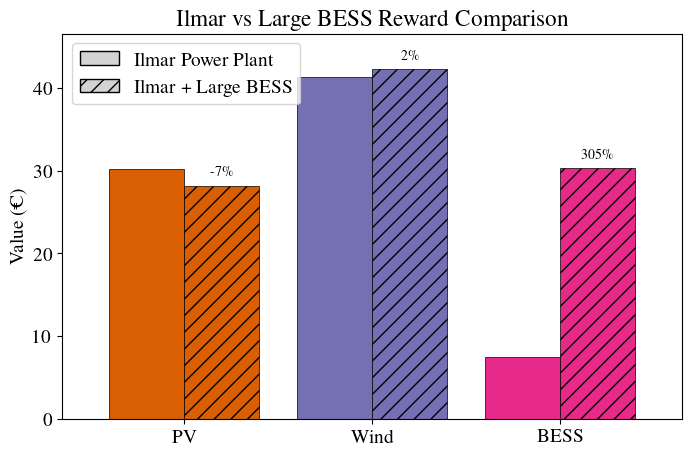

In [76]:
# plot df_compare in bar plot
fig, ax = plt.subplots(figsize=(8, 5))
df_compare.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

for col_idx, container in enumerate(ax.containers):
    # --- Determine Style per Column ---
    alpha = 1.0
    hatch = None
    
    # # "bars 1 and 2 should be alpha=.5" -> indices 0 and 1
    # if col_idx in [0, 1]:
    #     alpha = 0.5
        
    # "bars 2 and 4 should be hatch='//'" -> indices 1 and 3
    if col_idx in [1, 3]:
        hatch = '//'
        
    # --- Apply to each bar in the group ---
    # We zip with df_mean.index to know which device (PV/Wind/BESS) the bar belongs to
    for bar, label in zip(container, df_compare.index):
        # Set Color based on device (row index)
        color = device_colors.get(label)
        bar.set_facecolor(color)
        
        # Set Alpha
        bar.set_alpha(alpha)
        
        # Set Hatch
        bar.set_hatch(hatch)

baseline_col = 'Ilmar Power Plant'
comp_col = 'Ilmar + Large BESS'
# annotate above the right bars (comp_col)
for bar, label in zip(ax.containers[1], df_compare.index):  # right bars = comparison
    base = df_compare.loc[label, baseline_col]
    comp = df_compare.loc[label, comp_col]
    if base != 0:
        pct = (comp - base) / abs(base) * 100
        ax.annotate(f'{pct:.0f}\%',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, color='k')

# Final Formatting
ax.set_ylabel(r"Value (€)")
ax.set_title(r"Ilmar vs Large BESS Reward Comparison")
ax.set_ylim(0, df_compare.values.max()*1.1)  # add some space on top for annotations
plt.xticks(rotation=0) # Keep labels horizontal
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out
# plt.legend()
handles = [
    mpatches.Patch(facecolor='lightgrey', edgecolor='black', label='Ilmar Power Plant'),
    mpatches.Patch(facecolor='lightgrey', edgecolor='black', hatch='//', label='Ilmar + Large BESS')
]
ax.legend(handles=handles, loc='upper left')
plt.xticks(rotation=0) # Keep labels horizontal
# plt.grid()
# plt.savefig('pics/Ilmar_vs_large_bess.png', dpi=600, bbox_inches='tight')

## compare to other K values

In [67]:
Ks = [3, 10, 25]
# get PATH
path_BESS = 'pics/mp_optimal_spring_v5_K3/'
# get data
opt_df_forecasted = pd.read_csv(f'{path_BESS}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_forecasted.columns = [tuple(c for c in col if c!='nan') for col in opt_df_forecasted.columns.values]
opt_df_realized = pd.read_csv(f'{path_BESS}values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_realized.columns = [tuple(c for c in col if c!='nan') for col in opt_df_realized.columns.values]
# evaluate rewards
opt_df_rewards, _, _ = evaluate_full_game(opt_df_forecasted, opt_df_realized, MAKE_GAMES_SUPERADD=MAKE_GAMES_SUPERADD,
                                MAKE_REALIZED_SUPERADDITIVE=MAKE_REALIZED_SUPERADDITIVE,
                                print_warnings=False,
                                SPLIT_FORECASTED_REALIZED=SPLIT_FORECASTED_REALIZED)
# get PATH
# path_BESS = 'pics/mp_mid_k/'
path_BESS = 'pics/mp_optimal_spring_v3/'
# get data
opt_df_forecasted = pd.read_csv(f'{path_BESS}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_forecasted.columns = [tuple(c for c in col if c!='nan') for col in opt_df_forecasted.columns.values]
opt_df_realized = pd.read_csv(f'{path_BESS}values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_realized.columns = [tuple(c for c in col if c!='nan') for col in opt_df_realized.columns.values]
# evaluate rewards
mid_k_rewards, _, _ = evaluate_full_game(opt_df_forecasted, opt_df_realized, MAKE_GAMES_SUPERADD=MAKE_GAMES_SUPERADD,
                                MAKE_REALIZED_SUPERADDITIVE=MAKE_REALIZED_SUPERADDITIVE,
                                print_warnings=False,
                                SPLIT_FORECASTED_REALIZED=SPLIT_FORECASTED_REALIZED)                              

In [68]:
df_compare = pd.DataFrame(columns=devices, index=[f'Ilmar; K={k}' for k in Ks])
# get optimal rewards
opt_rewards = opt_df_rewards.xs('Realized', level=1)[devices].groupby(level=1).mean()
df_compare.loc[f'Ilmar; K={Ks[0]}'] = opt_rewards.loc['Reward']
df_compare.loc[f'Ilmar; K={Ks[2]}'] = df_rewards[devices].groupby(level=1).mean().loc['Realized-Reward']
k10_rewards = mid_k_rewards.xs('Realized', level=1)[devices].groupby(level=1).mean()
df_compare.loc[f'Ilmar; K={Ks[1]}'] = k10_rewards.loc['Reward']

In [69]:
df_compare = df_compare.transpose()

In [70]:
df_compare.sum()

Ilmar; K=3     104.251246
Ilmar; K=10    101.728537
Ilmar; K=25    100.837677
dtype: object

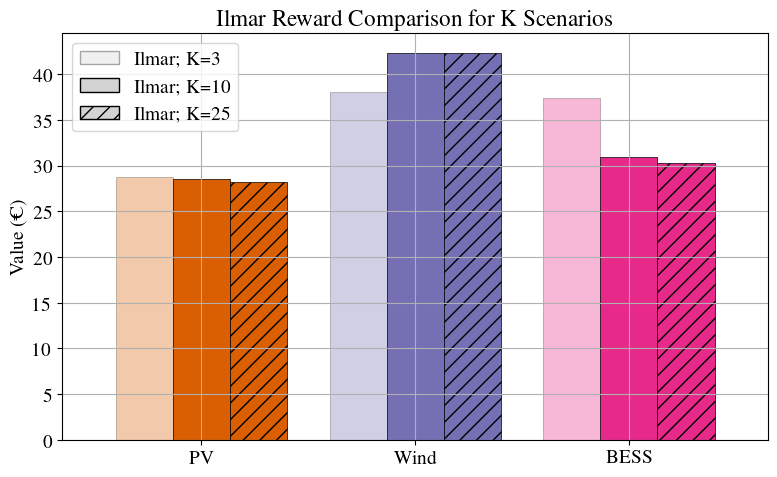

In [71]:
# plot df_compare in bar plot
fig, ax = plt.subplots(figsize=(8, 5))
df_compare.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

for col_idx, container in enumerate(ax.containers):
    # --- Determine Style per Column ---
    alpha = 1.0
    hatch = None
        
    # last bar should be hatch
    if col_idx in [0]:
        alpha = 0.33
    if col_idx in [2]:
        hatch = '//'
        
    # --- Apply to each bar in the group ---
    # We zip with df_mean.index to know which device (PV/Wind/BESS) the bar belongs to
    for bar, label in zip(container, df_compare.index):
        # Set Color based on device (row index)
        color = device_colors.get(label)
        bar.set_facecolor(color)
        
        # Set Alpha
        bar.set_alpha(alpha)
        
        # Set Hatch
        bar.set_hatch(hatch)

# Final Formatting
ax.set_ylabel(r"Value (€)")
ax.set_title(r"Ilmar Reward Comparison for K Scenarios")
plt.xticks(rotation=0) # Keep labels horizontal
handles = [
    mpatches.Patch(facecolor='lightgrey', edgecolor='black', alpha=.33, label=f'Ilmar; K={Ks[0]}'),
    mpatches.Patch(facecolor='lightgrey', edgecolor='black', label=f'Ilmar; K={Ks[1]}'),
    mpatches.Patch(facecolor='lightgrey', edgecolor='black', hatch='//', label=f'Ilmar; K={Ks[2]}')
]
ax.legend(handles=handles)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out
plt.tight_layout()
plt.grid()
# plt.savefig('custom_bar_plot.png')

## compare to other seasons

In [ ]:
path2 = 'pics/mp_ilmar_summer/'
path3 = 'pics/mp_ilmar_autumn/'

# TODO

## Analyze some individual games

In [ ]:
from src.get_optimal_bid import get_optimal_bid
import numpy as np

In [ ]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")
# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]
# Create extended cycle: first full alpha, then alpha=0.5
# colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]
# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\carlv\AppData\Local\Temp\ipykernel_24076\216728504.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [ ]:
# load bids dataframe
df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

In [ ]:
def map_idx_to_datetime(idx):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    return pd.Timestamp(vals[idx])
def map_datetime_to_idx(dt):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    for i, v in enumerate(vals):
        if v == dt:
            return i
    return None

In [ ]:
dict_idxs = {}
dict_realized_type_game = {}
for type_game in GAME_types_to_plot:
    dict_idxs[type_game] = df_rewards[df_rewards['F-Game Type']==type_game].index.get_level_values(0).unique()
    dict_realized_type_game[type_game] = df_rewards.loc[(dict_idxs[type_game], 'Realized-Reward'), 'R-Game Type'].values
    dict_idxs[type_game] = pd.to_datetime(dict_idxs['Shapley'])

In [ ]:
def bid_value(bids, rho, bid,
              return_prob=False):
    gamma = sum(rho for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [ ]:
def bids_to_values(bids, rho, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rho, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rho, b, return_prob=True) for b in bids])
        return gammas, values

In [ ]:
cols = df_bids.columns
idx_tuples = [eval(col) for col in df_bids.columns.values]
idx_frozensets = [frozenset(tup) for tup in idx_tuples]
the_map = {fs: col for fs, col in zip(idx_frozensets, cols)}

In [ ]:
MAP_METHOD_TO_TYPE = {'Shapley': 'Convex', 'Nucleolus': 'Supperadditive/Non-Empty Core', 'Sub-Game': 'Empty Core'}

## individual times plotting

At hour 2025-04-10 05:00:00, optimal partition is [frozenset({'BESS', 'Wind', 'PV'})] with value 8.44132.
Coalition frozenset({'BESS', 'Wind', 'PV'}) max value at index 0, bid: 8.441, value: 8.441
Coalition frozenset({'BESS', 'Wind', 'PV'}) max value at index 0, bid: 8.441, value: 8.441
Forecasted Game Values:
(PV,)               1.64332
(Wind,)             1.41079
(BESS,)             3.75000
(PV, Wind)          3.00921
(PV, BESS)          5.57926
(Wind, BESS)        5.62490
(PV, Wind, BESS)    8.44132
Name: (FFR + FCR-D, 2025-04-10 05:00:00), dtype: float64
Realized Game Values:
(PV,)               2.19125
(Wind,)             2.87146
(BESS,)             3.75000
(PV, Wind)          4.25600
(PV, BESS)          5.57926
(Wind, BESS)        5.62490
(PV, Wind, BESS)    8.44132
Name: (FFR + FCR-D, 2025-04-10 05:00:00), dtype: float64
Forecasted and Realized rewards:
                         PV      Wind      BESS F-Game Type R-Game Type
Forecasted-Value    1.64332   1.41079      3.75     Sha

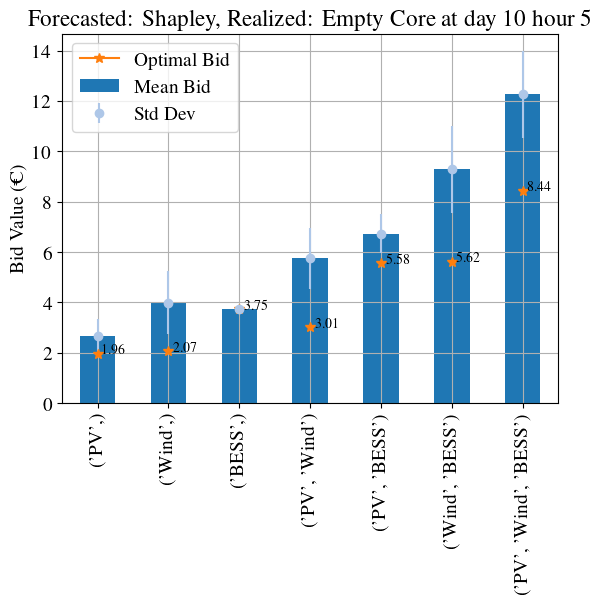

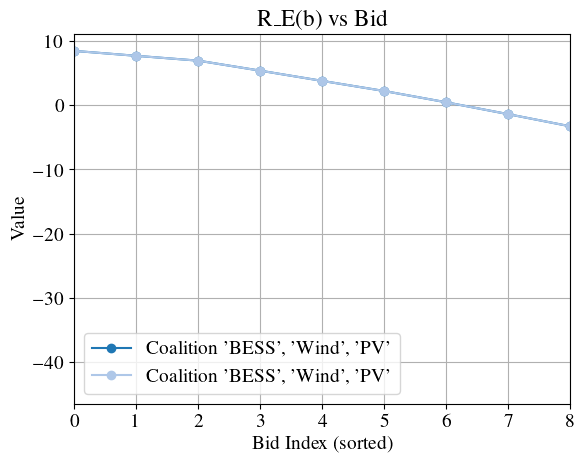

At hour 2025-04-10 12:00:00, optimal partition is [frozenset({'BESS', 'Wind', 'PV'})] with value 55.8376.
Coalition frozenset({'BESS', 'Wind', 'PV'}) max value at index 0, bid: 8.849, value: 8.849
Coalition frozenset({'BESS', 'Wind', 'PV'}) max value at index 0, bid: 8.849, value: 8.849
Forecasted Game Values:
(PV,)               27.70305
(Wind,)              0.00000
(BESS,)             23.66250
(PV, Wind)          18.84127
(PV, BESS)          54.69215
(Wind, BESS)        23.66250
(PV, Wind, BESS)    55.83760
Name: (FFR + FCR-D, 2025-04-10 12:00:00), dtype: float64
Realized Game Values:
(PV,)               31.02965
(Wind,)              0.00000
(BESS,)             23.66250
(PV, Wind)          20.31959
(PV, BESS)          54.69215
(Wind, BESS)        23.66250
(PV, Wind, BESS)    55.83760
Name: (FFR + FCR-D, 2025-04-10 12:00:00), dtype: float64
Forecasted and Realized rewards:
                          PV      Wind       BESS F-Game Type R-Game Type
Forecasted-Value    27.70305       0.0 

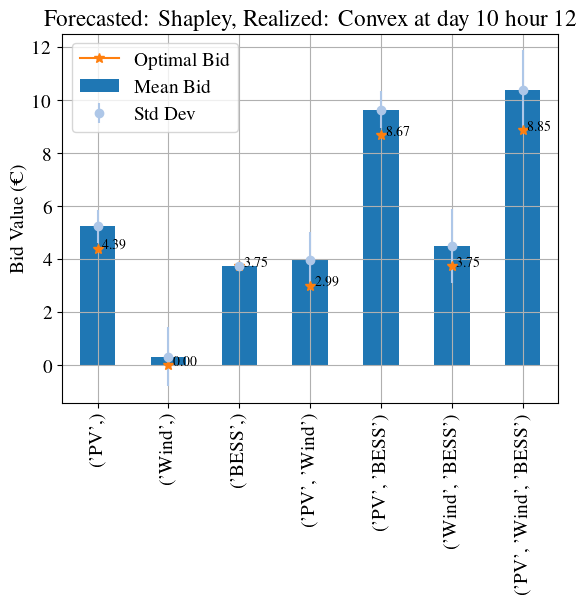

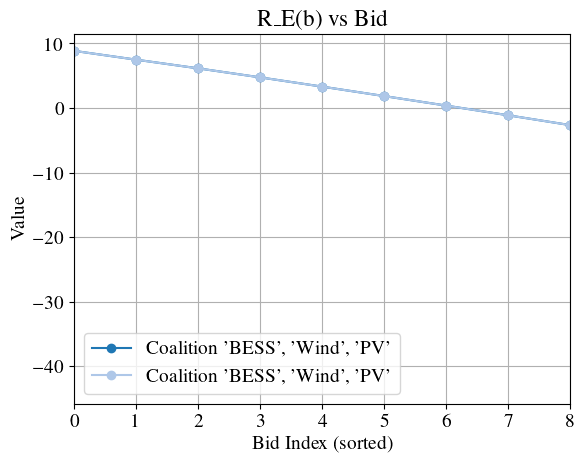

In [ ]:
MAX_GAMES_TO_PLOT = 2  # max games per type to plot

type_game = 'Shapley'
# if len(dict_idxs[type_game]) == 0:
#     continue
if len(dict_idxs[type_game]) < MAX_GAMES_TO_PLOT:
    MAX_GAMES_TO_PLOT = len(dict_idxs[type_game])

# pick 5 random indexes
np.random.seed(42)
these_idxs = np.random.choice(len(dict_idxs[type_game]), size=MAX_GAMES_TO_PLOT, replace=False)

dt_idxs = dict_idxs[type_game][these_idxs]
realized_methods = dict_realized_type_game[type_game][these_idxs]

K_errors = len(df_bids.loc[dt_idxs[0]])
probs = [1/K_errors for _ in range(K_errors)]
for j, dt in enumerate(dt_idxs):
    # print(dvpps_infos[service].loc[dt])
    # visualize mean and std of each column
    plt.figure()
    plt.title(f'Forecasted: {type_game}, Realized: {MAP_METHOD_TO_TYPE[realized_methods[j]]} at day {dt.day} hour {dt.hour}')
    df_bids.loc[dt].mean(axis=0).plot(kind='bar', label='Mean Bid')
    # plot min max with error bars
    plt.errorbar(x=df_bids.loc[dt].columns, y=df_bids.loc[dt].mean(axis=0), yerr=df_bids.loc[dt].std(axis=0), fmt='o', label='Std Dev',
                color=base_colors[1])
    # compute optimal bid for each coalition and plot as star marker
    dict_opt_bids = {}
    for coalition in df_bids.loc[dt].columns:
        c_bids = np.squeeze(df_bids.loc[dt, [coalition]].values)
        b_star_coalition, value_wo_price, gamma = get_optimal_bid(c_bids, probs, return_reward=True)
        dict_opt_bids[coalition] = b_star_coalition
        # plot as star marker
        plt.plot(coalition, b_star_coalition, marker='*', markersize=7, label='Optimal Bid' if coalition==df_bids.loc[dt].columns[0] else "", color=base_colors[2])
        # annotate value of optimal bid to the right of the star
        plt.annotate(f'{b_star_coalition:.2f}', (coalition, b_star_coalition), textcoords="offset points", xytext=(12, 0), ha='center', fontsize=10)
    plt.ylabel('Bid Value (€)')
    plt.grid()
    plt.legend()

    # next, also plot th eindividual bids in line chart for non-superadditiv coalitions
    idx_str = str(dt)        
    v = {frozenset(k): val for k, val in df_forecasted.loc[(service, idx_str)].items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    max_value, coalitions = solve_optimal_partition(v)
    print(f'At hour {dt}, optimal partition is {coalitions} with value {max_value}.')
    # plot line chart for this coalition
    plt.figure()
    x_ks = np.arange(K_errors)
    # add grand coalition
    coalitions.append(frozenset(players))

    for coalition in coalitions:
        # convert to columns
        col = the_map[coalition]
        the_bids = df_bids.loc[dt, col].values.tolist()
        the_bids.sort()
        # the_bids = the_bids[::-1]
        # convert bids to values
        vals = bids_to_values(the_bids, probs[0])
        # indicate dict_opt_bids in plot
        plt.plot(x_ks, vals, marker='o', label=f'Coalition {set(coalition)}')
        # print idx and bid of max value
        max_idx = np.argmax(vals)
        print(f"Coalition {coalition} max value at index {max_idx}, bid: {the_bids[max_idx]:.3f}, value: {vals[max_idx]:.3f}")

    # print forecasted and realized game values and reward splits
    print("Forecasted Game Values:")
    print(df_forecasted.loc[(service, idx_str)])
    print("Realized Game Values:")
    print(df_realized.loc[(service, idx_str)])
    print("Forecasted and Realized rewards:")
    print(df_rewards.loc[idx_str])

    plt.xlabel('Bid Index (sorted)')
    plt.ylabel('Value')
    plt.title('R_E(b) vs Bid')
    plt.grid(True)
    plt.xlim((0, 8))
    plt.legend()
    plt.show()

## Plot Examples for Convex, Non-Empty Core and Sub-Coaltiions

In [ ]:
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = 14.9
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = 15
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = 22.1
v[frozenset({'PV', 'Wind', 'BESS'})] = 22.2

In [ ]:
# realized game
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = -44.6
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = -45.1
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = -66.3
v[frozenset({'PV', 'Wind', 'BESS'})] = -66.7

In [ ]:
# realized game
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 15.9
v[frozenset({'Wind'})] = 40.2
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = 53.1
v[frozenset({'PV', 'BESS'})] = 30.3
v[frozenset({'Wind', 'BESS'})] = 43.6
v[frozenset({'PV', 'Wind', 'BESS'})] = 58.1

In [ ]:
v[frozenset({'PV'})] + v[frozenset({'Wind'})]

56.1

In [ ]:
v_new = make_game_superadditive(v, ['PV', 'Wind', 'BESS'])

In [ ]:
v_new

{frozenset(): 0,
 frozenset({'PV'}): 15.9,
 frozenset({'Wind'}): 40.2,
 frozenset({'BESS'}): 0,
 frozenset({'PV', 'Wind'}): 56.1,
 frozenset({'BESS', 'PV'}): 30.3,
 frozenset({'BESS', 'Wind'}): 43.6,
 frozenset({'BESS', 'PV', 'Wind'}): 70.5}

In [ ]:
is_convex_game(v_new, ['PV', 'Wind', 'BESS'], print_warnings=True)

Game is not convex: frozenset({'BESS', 'PV'}), frozenset({'BESS', 'Wind'})


False

In [ ]:
get_shapley_value(v, ['PV', 'Wind', 'BESS'])

{'PV': 17.333333333333332,
 'Wind': 36.13333333333333,
 'BESS': 4.633333333333333}

In [ ]:
from src.game_theory_helpers import is_convex_game, game_is_superadditive, core_nonempty

In [ ]:
core_nonempty(v, ['PV', 'Wind', 'BESS'])

False